In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import tensorflow as tf
print(tf.__version__)


2.2.0-rc2


In [0]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-04-04 12:06:48--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2020-04-04 12:06:48 (116 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [0]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [0]:
training_size = 20000

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [0]:
vocab_size = 10000 # integer encode the documents
embedding_dim = 16 #dimension
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok) #https://keras.io/preprocessing/text/
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index #dictionary of words and their uniquely assigned integers

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type) #https://keras.io/preprocessing/sequence/#pad_sequences

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [0]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs =10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
625/625 - 2s - loss: 0.6676 - accuracy: 0.5772 - val_loss: 0.5990 - val_accuracy: 0.6245
Epoch 2/10
625/625 - 2s - loss: 0.4342 - accuracy: 0.8287 - val_loss: 0.3864 - val_accuracy: 0.8326
Epoch 3/10
625/625 - 2s - loss: 0.3084 - accuracy: 0.8773 - val_loss: 0.3525 - val_accuracy: 0.8517
Epoch 4/10
625/625 - 2s - loss: 0.2576 - accuracy: 0.8996 - val_loss: 0.3466 - val_accuracy: 0.8512
Epoch 5/10
625/625 - 2s - loss: 0.2210 - accuracy: 0.9146 - val_loss: 0.3451 - val_accuracy: 0.8565
Epoch 6/10
625/625 - 2s - loss: 0.1950 - accuracy: 0.9275 - val_loss: 0.3570 - val_accuracy: 0.8557
Epoch 7/10
625/625 - 2s - loss: 0.1731 - accuracy: 0.9355 - val_loss: 0.3623 - val_accuracy: 0.8554
Epoch 8/10
625/625 - 2s - loss: 0.1544 - accuracy: 0.9445 - val_loss: 0.3801 - val_accuracy: 0.8530
Epoch 9/10
625/625 - 2s - loss: 0.1392 - accuracy: 0.9514 - val_loss: 0.3950 - val_accuracy: 0.8533
Epoch 10/10
625/625 - 2s - loss: 0.1260 - accuracy: 0.9544 - val_loss: 0.4214 - val_accuracy: 0.8465

In [12]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [18]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [15]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.6785109 ]
 [0.05010872]]


In [0]:
#https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Lesson%202.ipynb

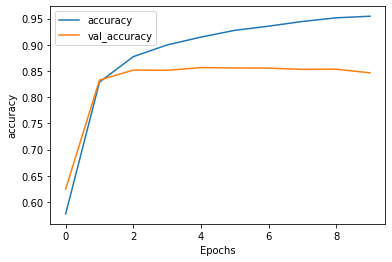

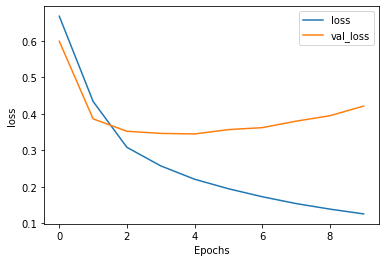

In [16]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")